In [205]:
import pandas as pd
import numpy as np
import  seaborn as sns
from sklearn.model_selection import  cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import  LinearRegression, Ridge
from sklearn.ensemble import  GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb

In [206]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [207]:
for col in train_df.columns:
    if(col!="SalePrice"):
        if(train_df[col].dtype=="object"):
            unique_cat = test_df[col].unique()
            train_df = train_df[train_df[col].isin(unique_cat) | train_df[col].isnull()]


In [208]:
for col in train_df.columns:
    if (col != "SalePrice"):
        if (train_df[col].dtype == "object"):
            print(col)
            print(f"train is {train_df[col].nunique()}")
            print(f"test is {test_df[col].nunique()}")
            print()
# still problem in GarageCond

MSZoning
train is 5
test is 5

Street
train is 2
test is 2

Alley
train is 2
test is 2

LotShape
train is 4
test is 4

LandContour
train is 4
test is 4

Utilities
train is 1
test is 1

LotConfig
train is 5
test is 5

LandSlope
train is 3
test is 3

Neighborhood
train is 25
test is 25

Condition1
train is 9
test is 9

Condition2
train is 5
test is 5

BldgType
train is 5
test is 5

HouseStyle
train is 7
test is 7

RoofStyle
train is 6
test is 6

RoofMatl
train is 4
test is 4

Exterior1st
train is 13
test is 13

Exterior2nd
train is 15
test is 15

MasVnrType
train is 3
test is 3

ExterQual
train is 4
test is 4

ExterCond
train is 5
test is 5

Foundation
train is 6
test is 6

BsmtQual
train is 4
test is 4

BsmtCond
train is 4
test is 4

BsmtExposure
train is 4
test is 4

BsmtFinType1
train is 6
test is 6

BsmtFinType2
train is 6
test is 6

Heating
train is 4
test is 4

HeatingQC
train is 5
test is 5

CentralAir
train is 2
test is 2

Electrical
train is 4
test is 4

KitchenQual
train is 4
t

In [209]:
col = "GarageCond"
print(f"train is {train_df[col].unique()}")
print(f"test is {test_df[col].unique()}")

train is ['TA' 'Fa' nan 'Gd' 'Po']
test is ['TA' nan 'Fa' 'Gd' 'Po' 'Ex']


<Axes: xlabel='GarageCond', ylabel='SalePrice'>

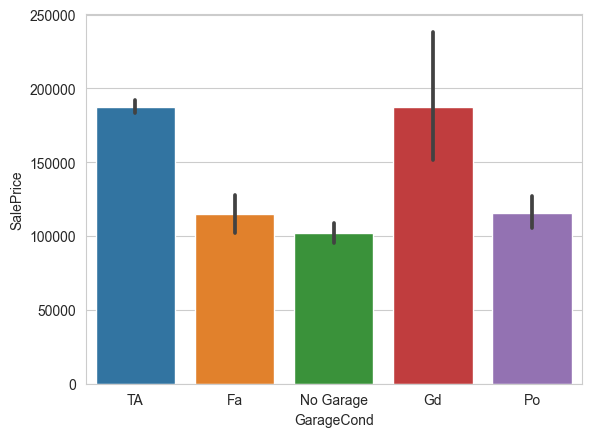

In [210]:
train_df["GarageCond"].fillna("No Garage",inplace=True)
test_df["GarageCond"].fillna("No Garage",inplace=True)

test_df["GarageCond"] = test_df["GarageCond"].apply(lambda x: "Gd" if x=="Ex" else x);
sns.barplot(x="GarageCond",y="SalePrice",data=train_df)

In [211]:
mapping = {
    20:"a",
    30:"b",
    40:"c",
    45:"d",
    50:"e",
    60:"f",
    70:"g",
    75:"h",
    80:"i",
    85:"j",
    90:"k",
    120:"l",
    150:"m",
    160:"n",
    180:"o",
    190:"p",

}

train_df["MSSubClass"]= train_df["MSSubClass"].map(mapping)
test_df["MSSubClass"]= test_df["MSSubClass"].map(mapping)
test_df["MSSubClass"] = test_df["MSSubClass"].apply(lambda x: "n" if x=="m" else x)

In [212]:
print(f"train is {train_df[col].unique()}")
print(f"test is {test_df[col].unique()}")

train is ['TA' 'Fa' 'No Garage' 'Gd' 'Po']
test is ['TA' 'No Garage' 'Fa' 'Gd' 'Po']


In [213]:
null_cols = []

for col in train_df.columns:
    if train_df[col].isna().sum() > 0:
        null_cols.append({col: train_df[col].isna().sum()})

null_cols

[{'LotFrontage': 253},
 {'Alley': 1343},
 {'MasVnrType': 850},
 {'MasVnrArea': 8},
 {'BsmtQual': 36},
 {'BsmtCond': 36},
 {'BsmtExposure': 37},
 {'BsmtFinType1': 36},
 {'BsmtFinType2': 37},
 {'Electrical': 1},
 {'FireplaceQu': 679},
 {'GarageType': 78},
 {'GarageYrBlt': 78},
 {'GarageFinish': 78},
 {'GarageQual': 78},
 {'PoolQC': 1427},
 {'Fence': 1156},
 {'MiscFeature': 1380}]

In [214]:
fill_by_mean = ["LotFrontage","MasVnrArea","GarageYrBlt"]
fill_by_not_present = ["Alley","MasVnrType","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","FireplaceQu","GarageType","GarageFinish","GarageQual","PoolQC","Fence","MiscFeature","BsmtFinType2"]

In [215]:
train_df.drop(columns=["Electrical"],inplace=True)
test_df.drop(columns=["Electrical"],inplace=True)

In [216]:
train_df[fill_by_not_present] = train_df[fill_by_not_present].fillna("Not Present")
test_df[fill_by_not_present] = test_df[fill_by_not_present].fillna("Not Present")

In [217]:
train_df[fill_by_mean] = train_df[fill_by_mean].fillna(train_df[fill_by_mean].mean())
test_df[fill_by_mean] = test_df[fill_by_mean].fillna(test_df[fill_by_mean].mean())

In [218]:
for col in test_df.columns:
    if test_df[col].isna().sum() > 0:
        if(test_df[col].dtype=="object"):
            print(col)
            test_df[col] = test_df[col].fillna(test_df[col].mode().iloc[0])
        else:
            test_df[col] = test_df[col].fillna(test_df[col].mean())

MSZoning
Utilities
Exterior1st
Exterior2nd
KitchenQual
Functional
SaleType


In [219]:
categorical_cols = []

# Iterate over the columns of the train_df DataFrame
for col in train_df.columns:
    if train_df[col].dtype == "object":
        categorical_cols.append(col)

test_df = pd.get_dummies(test_df, columns=categorical_cols)
train_df = pd.get_dummies(train_df, columns=categorical_cols)
train_df.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,7,5,2003,2003,196.0,706,0,...,False,False,False,True,False,False,False,False,True,False
1,2,80.0,9600,6,8,1976,1976,0.0,978,0,...,False,False,False,True,False,False,False,False,True,False
2,3,68.0,11250,7,5,2001,2002,162.0,486,0,...,False,False,False,True,False,False,False,False,True,False
3,4,60.0,9550,7,5,1915,1970,0.0,216,0,...,False,False,False,True,True,False,False,False,False,False
4,5,84.0,14260,8,5,2000,2000,350.0,655,0,...,False,False,False,True,False,False,False,False,True,False


In [220]:
def evaluate_model(model,X,y):
    model_name = model.__class__.__name__
    scores = cross_val_score(model, X, np.log(y), scoring='neg_mean_squared_error', cv=5)
    mse_scores = -scores

    print(f"The RMSE score for {model_name} is {mse_scores.mean()}")


In [221]:
X = train_df.drop(columns=["SalePrice","Id"])
y = train_df.SalePrice

In [222]:
# models = [Ridge(),RandomForestRegressor(),lgb.LGBMRegressor(),xgb.XGBRegressor(),GradientBoostingRegressor()]
# for model in models:
#     evaluate_model(model,X,y)
#     print()

In [223]:
best_model  = GradientBoostingRegressor()
evaluate_model(best_model,X,y)

best_model.fit(X,y)

The RMSE score for GradientBoostingRegressor is 0.01617924425471222


GradientBoostingRegressor()

In [224]:
X = test_df.drop(columns=["Id"])
predictions = best_model.predict(X)

predictions = pd.DataFrame({'Id':test_df.Id,'SalePrice':predictions})
predictions.head()


,Id,SalePrice
0,1461,122663.465572
1,1462,160839.241143
2,1463,181242.455891
3,1464,179969.438337
4,1465,193674.876007


In [225]:
predictions.to_csv("submission.csv",index=False)